# Health Disease Detection Using  Probability and Stastics

## **Problem Statement:**
## Predicting the Impact of Lifestyle Choices on Multiple Chronic Diseases Using Statistical Analysis and Regression models ?

Importing Required Libraries and Data

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_los
import pandas as pd
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
data = pd.read_csv('CVD_cleaned.csv')
data.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


### Data Flitering

In [8]:
data['General_Health'] = data['General_Health'].replace({
    'Excellent': 'Very Good',
    'Fair': 'Good'
})

data['Diabetes'] = data['Diabetes'].replace({
    'No, pre-diabetes or borderline diabetes': 'No',
    'Yes, but female told only during pregnancy': 'Yes'
})


def categorize_consumption(value, thresholds, labels):
    for i, threshold in enumerate(thresholds):
        if value <= threshold:
            return labels[i]
    return labels[-1]

def categorize_bmi(value):
    if value < 18.5:
        return 'Under Weight'
    elif value <= 24.9:
        return 'Fit'
    else:

        return 'Obese'

# Update the thresholds for monthly consumption
consumption_columns_monthly = {
    'Alcohol_Consumption': ([0, 7, 15], ['No', 'Low', 'Medium', 'High']),
    'Fruit_Consumption': ([0, 30, 60], ['No', 'Low', 'Medium', 'High']),
    'Green_Vegetables_Consumption': ([0, 30, 60], ['No', 'Low', 'Medium', 'High']),
    'FriedPotato_Consumption': ([0, 4, 12], ['No', 'Low', 'Medium', 'High'])
}
data['BMI_Category'] = data['BMI'].apply(categorize_bmi)
for column, (thresholds, labels) in consumption_columns_monthly.items():
    data[column + '_Category'] = data[column].apply(categorize_consumption, args=(thresholds, labels))

# Show the updated dataframe with new columns
data[['Alcohol_Consumption_Category', 'Fruit_Consumption_Category', 'Green_Vegetables_Consumption_Category',
      'FriedPotato_Consumption_Category', 'BMI_Category']].head()


,Alcohol_Consumption_Category,Fruit_Consumption_Category,Green_Vegetables_Consumption_Category,FriedPotato_Consumption_Category,BMI_Category
0,No,Low,Low,Medium,Under Weight
1,No,Low,No,Low,Obese
2,Low,Low,Low,High,Obese
3,No,Low,Low,Medium,Obese
4,No,Low,Low,No,Fit


### Data Exploration

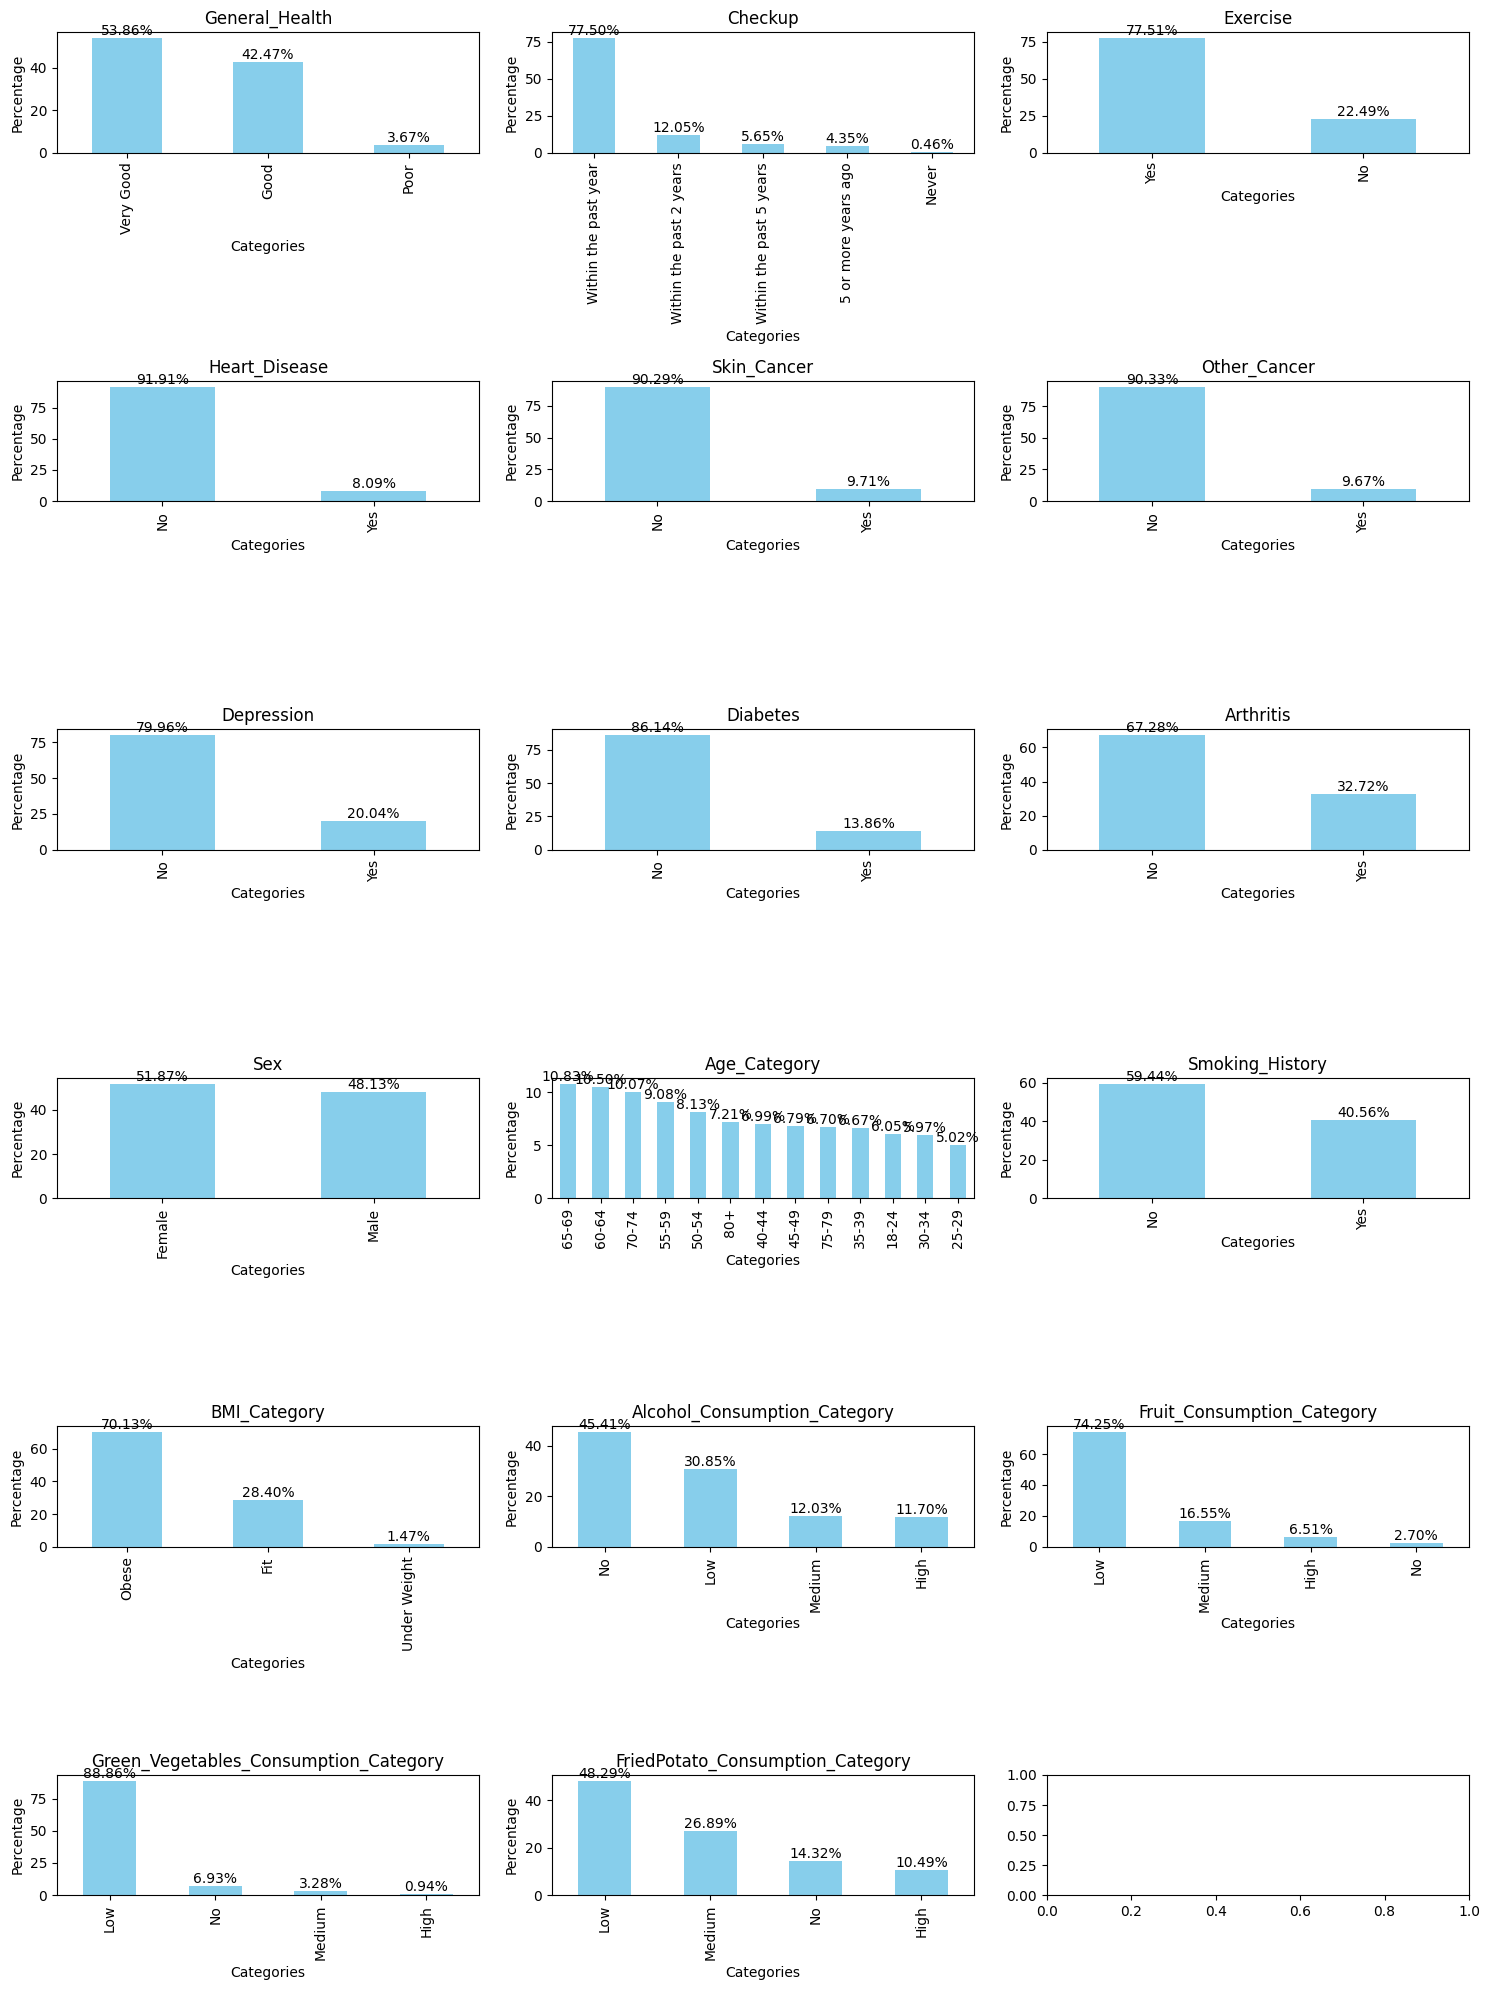

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Load your data
data = data

# Select only the categorical columns for plotting
categorical_columns = data.select_dtypes(include=['object']).columns

# Set up the plotting area
fig, axes = plt.subplots(nrows=len(categorical_columns)//3 + 1, ncols=3, figsize=(15, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Iterate through the categorical columns and create a bar plot for each
for ax, column in zip(axes.flatten(), categorical_columns):
    # Calculate the percentage of each category
    value_counts = data[column].value_counts(normalize=True) * 100
    bars = value_counts.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(column)
    ax.set_ylabel('Percentage')
    ax.set_xlabel('Categories')

    # Annotate the bars
    for bar in bars.patches:
        bar_height = bar.get_height()
        ax.annotate(f'{bar_height:.2f}%',
                    (bar.get_x() + bar.get_width() / 2, bar_height),
                    ha='center', va='bottom')

# Adjust layout to make room for the plots
plt.tight_layout()
plt.show()


### Explorartory Data Analysis (EDA)

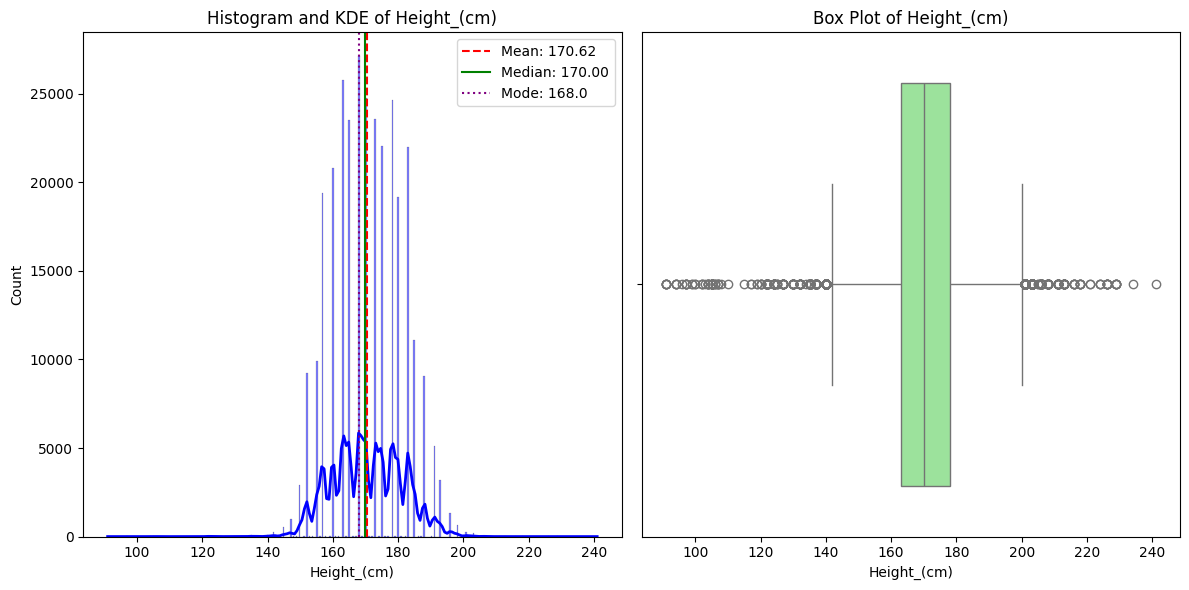

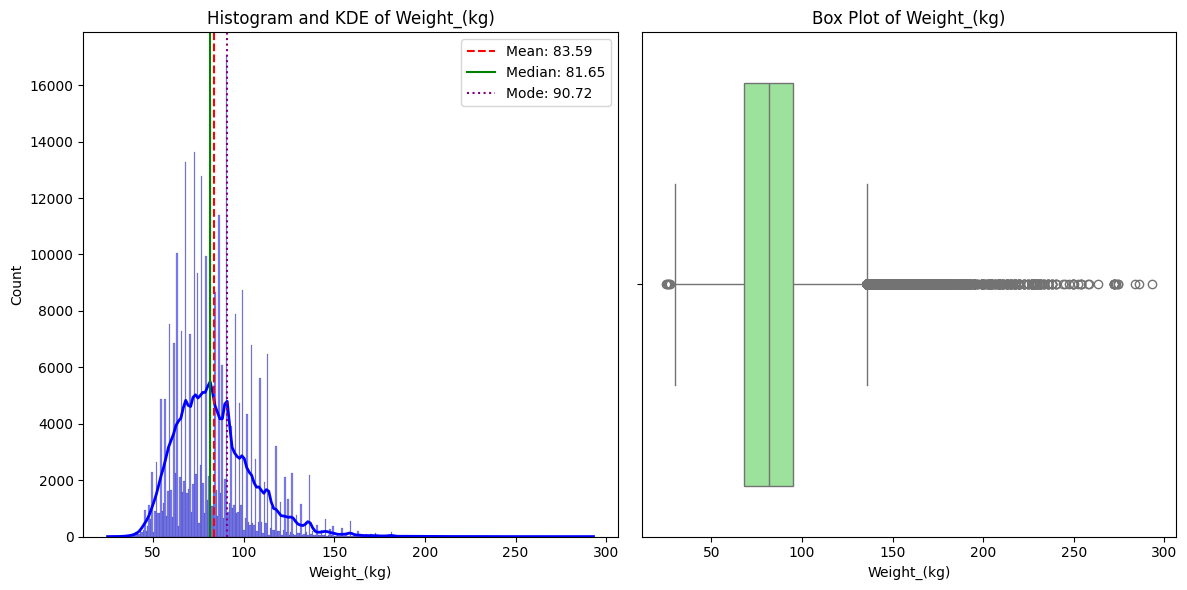

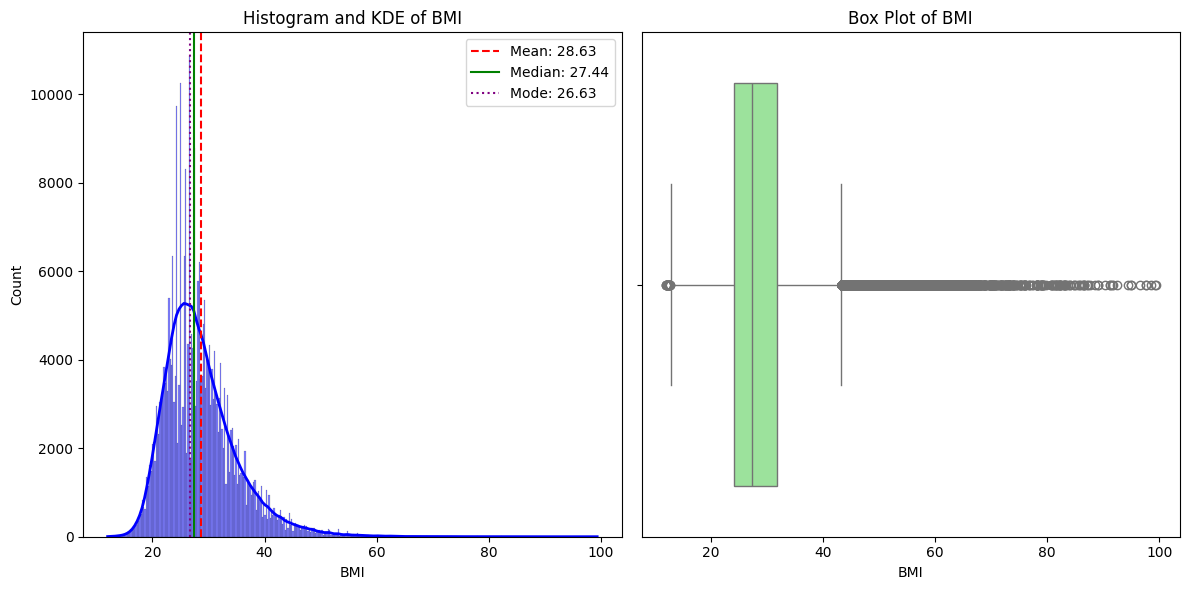

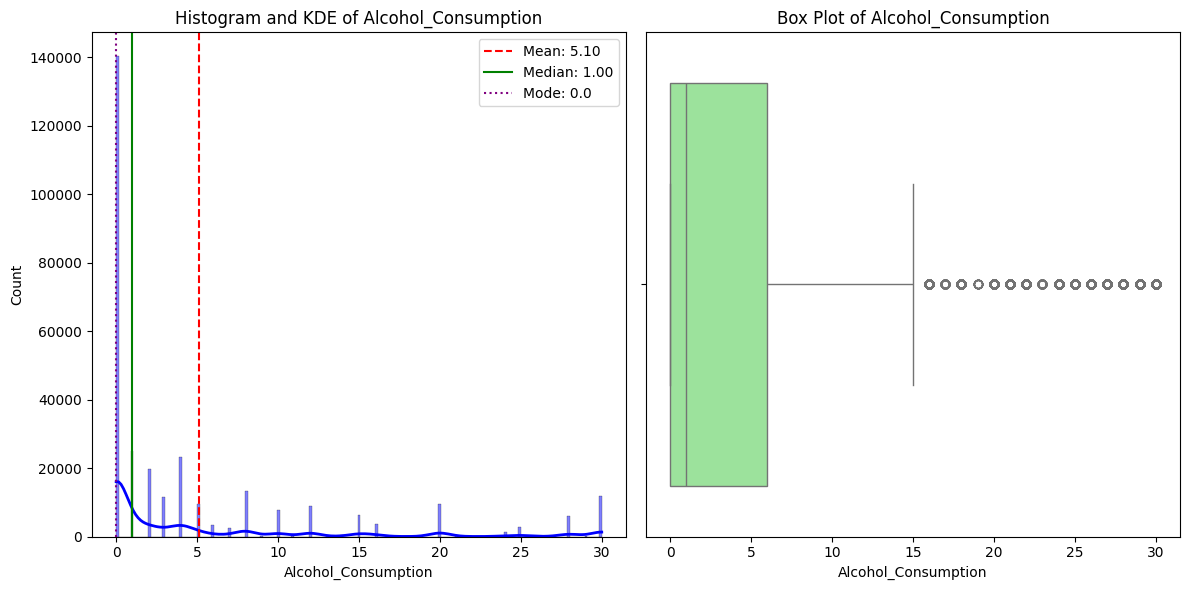

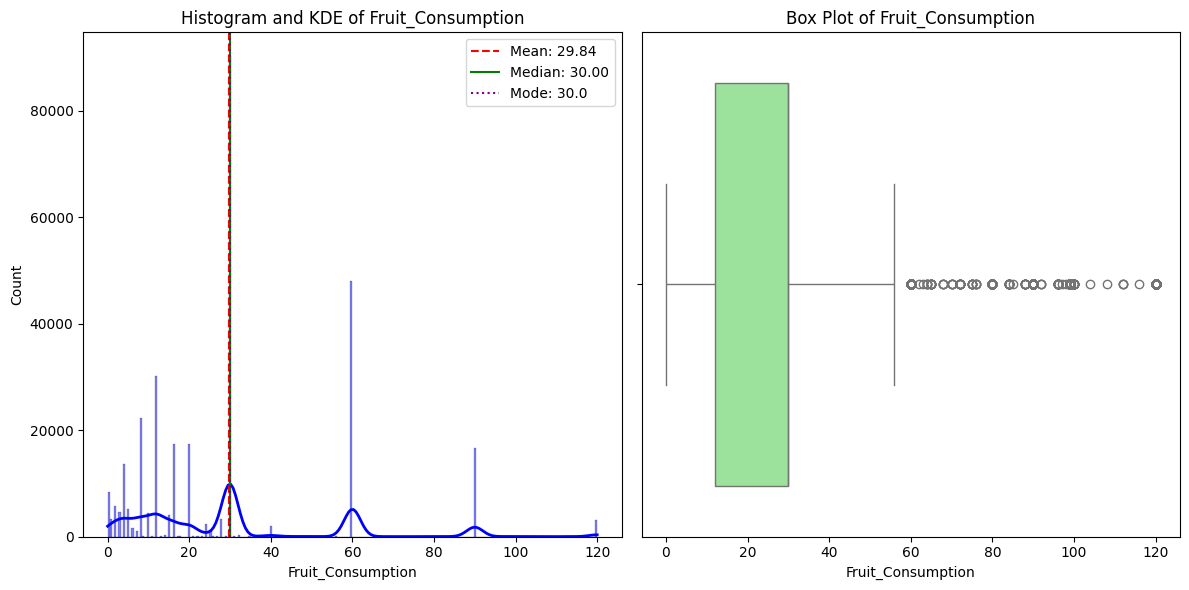

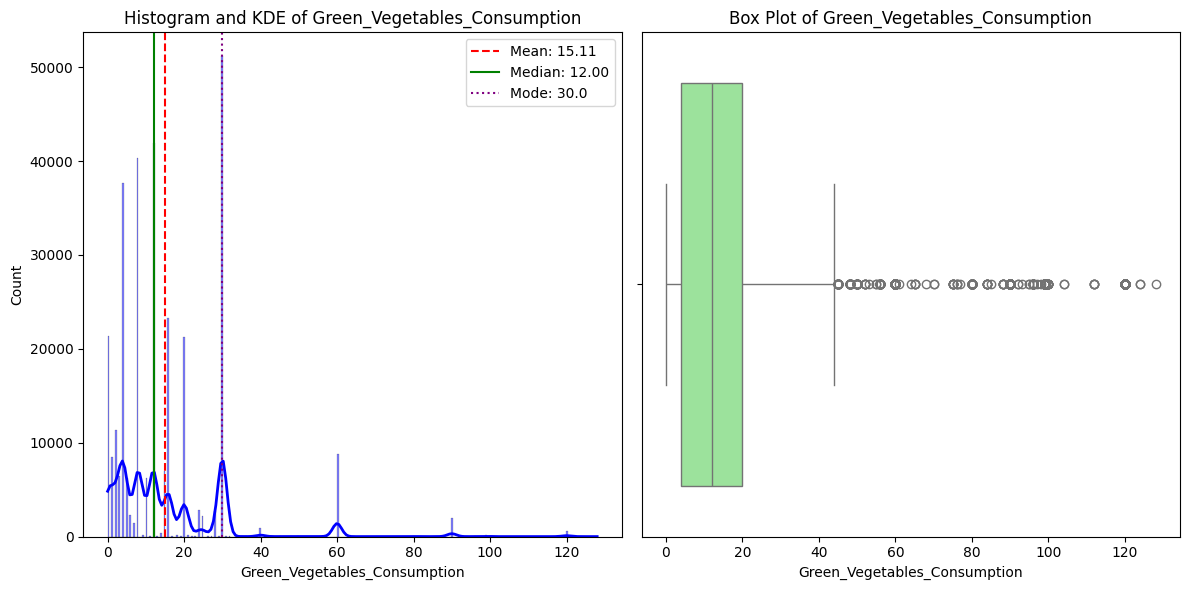

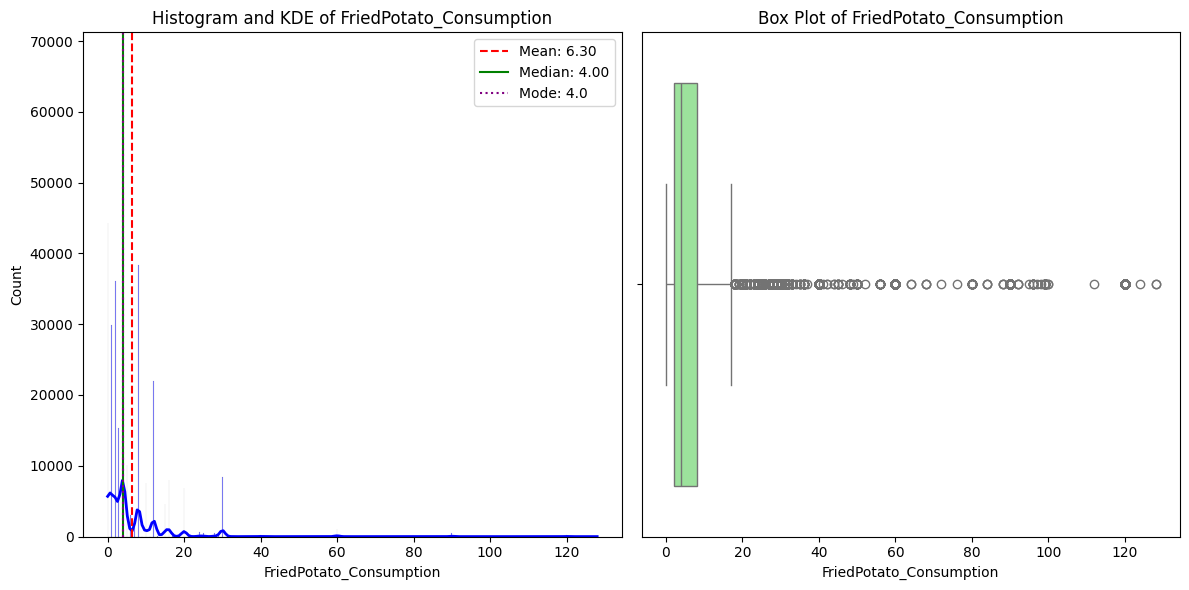

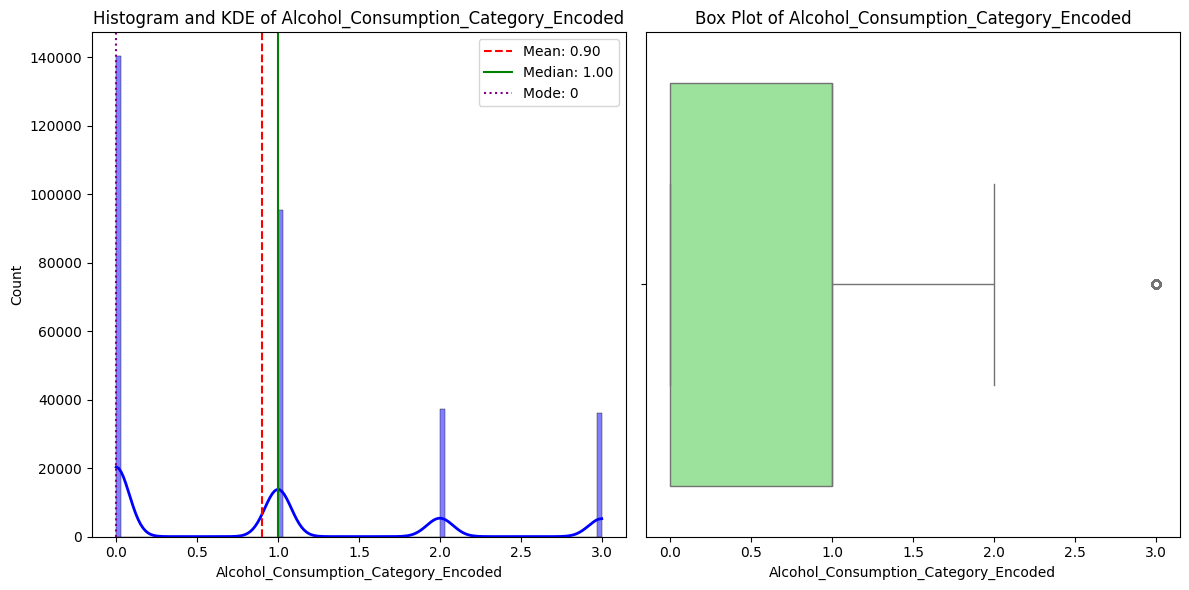

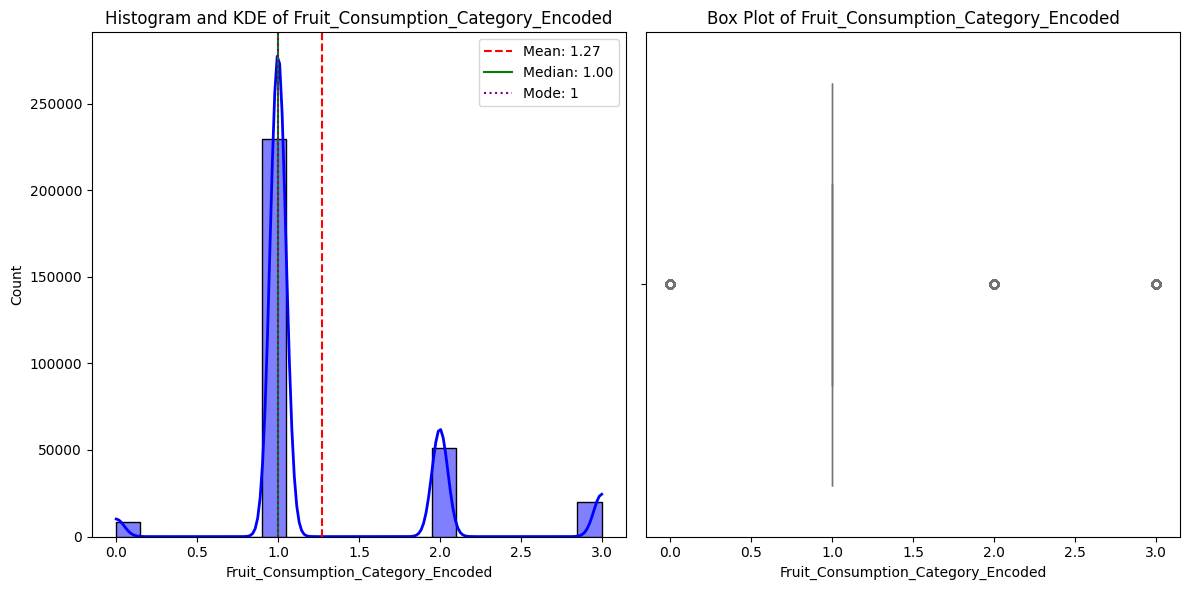

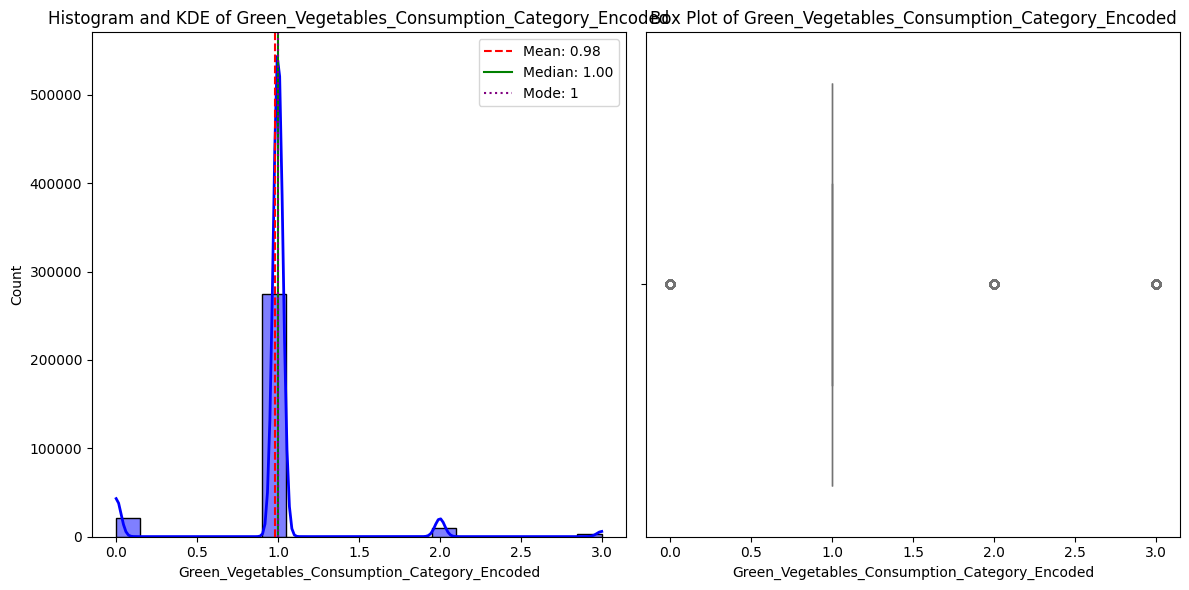

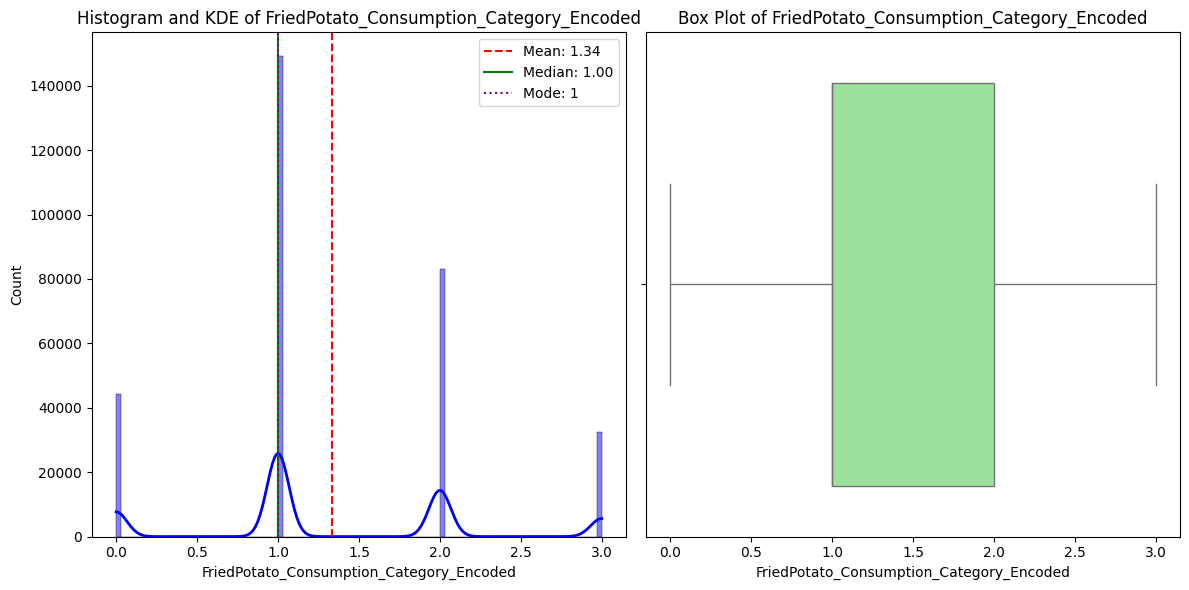

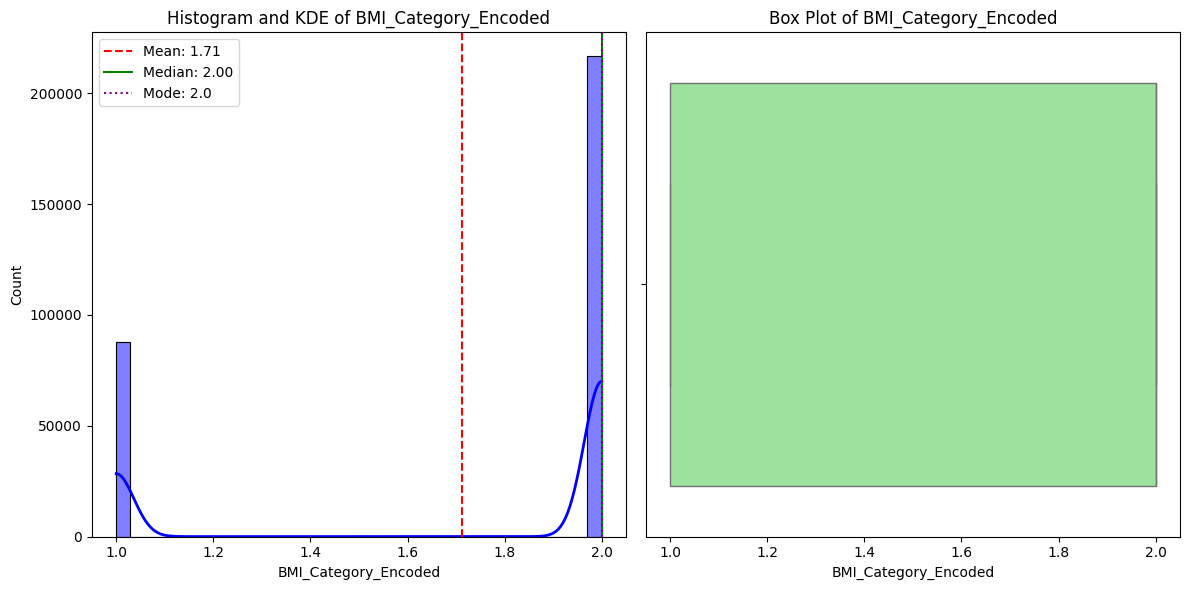

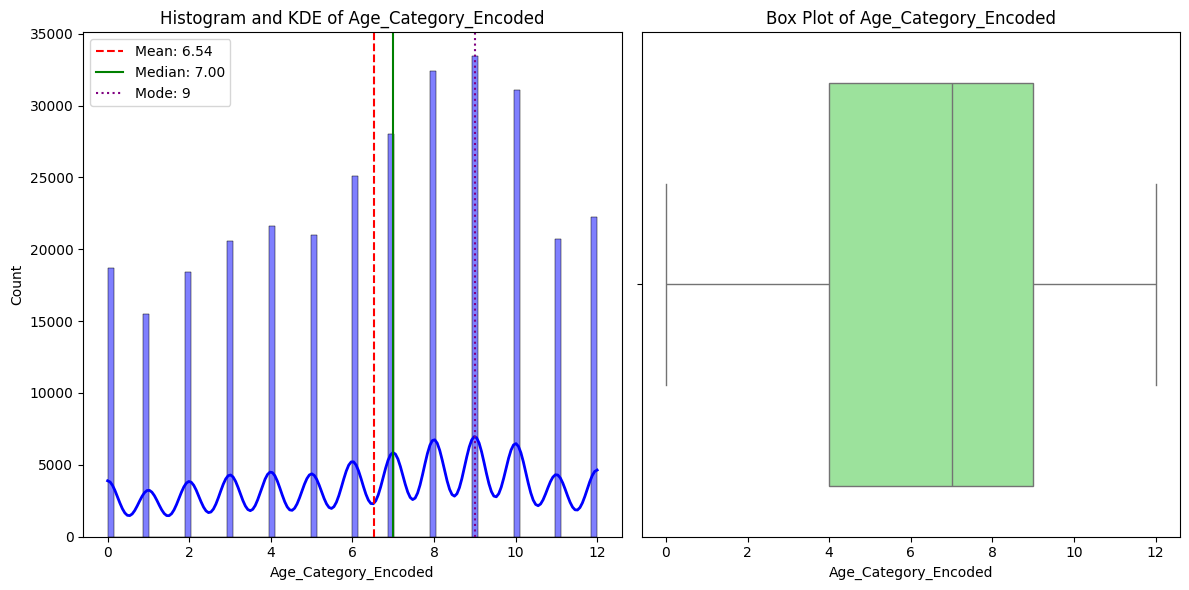

In [12]:
# Identify numerical columns and exclude encoded columns
encoded_columns = ['Heart_Disease_Encoded', 'Skin_Cancer_Encoded', 'Other_Cancer_Encoded',
                   'Depression_Encoded', 'Diabetes_Encoded', 'Arthritis_Encoded']
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = [col for col in numerical_cols if col not in encoded_columns]

# Generate plots for each numerical column
for column in numerical_cols:
    # Create a new figure for each column's histogram and box plot
    plt.figure(figsize=(12, 6))

    # Histogram with KDE
    plt.subplot(1, 2, 1)
    sns.histplot(data[column], kde=True, color='blue', line_kws={'linewidth':2})
    mean_value = data[column].mean()
    median_value = data[column].median()
    mode_value = data[column].mode().dropna().values[0] if not data[column].mode().empty else None

    # Add vertical lines for mean, median, and mode
    plt.axvline(mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f}')
    plt.axvline(median_value, color='green', linestyle='-', label=f'Median: {median_value:.2f}')
    if mode_value is not None:
        plt.axvline(mode_value, color='purple', linestyle=':', label=f'Mode: {mode_value}')
    plt.legend()
    plt.title(f'Histogram and KDE of {column}')

    # Box plot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[column], color='lightgreen')
    plt.title(f'Box Plot of {column}')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


### Benouils Distribution

<ipython-input-15-f1fe2e6af622>:19: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(x, pmf, use_line_collection=True)


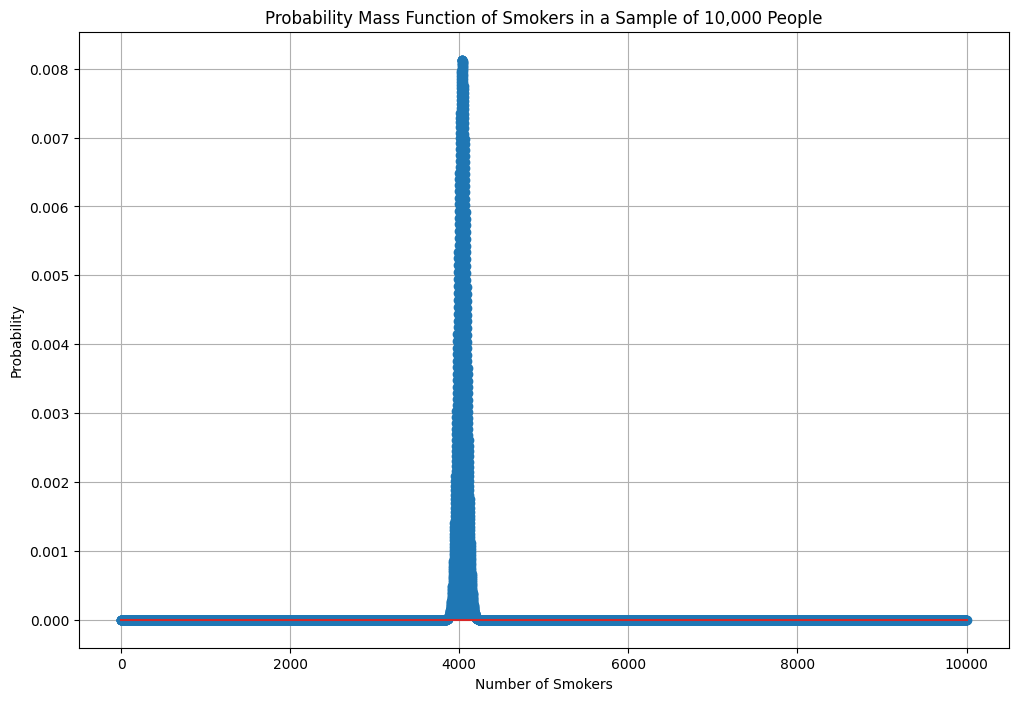

In [15]:


# Assuming you have a DataFrame 'data' with a column 'Smoking_History'
# that contains 'Yes' for smokers and 'No' for non-smokers.

# Sample a subset of the data if it's very large
sample_data = data.sample(n=10000, random_state=42)

# Calculate the probability of being a smoker
p = (sample_data['Smoking_History'] == 'Yes').mean()

# Number of trials
n = 10000

# Generate binomial distribution data
x = np.arange(0, n+1)
pmf = binom.pmf(x, n, p)

# Plotting the PMF
plt.figure(figsize=(12, 8))
plt.stem(x, pmf, use_line_collection=True)
plt.title('Probability Mass Function of Smokers in a Sample of 10,000 People')
plt.xlabel('Number of Smokers')
plt.ylabel('Probability')
plt.grid(True)
plt.show()


### Generating Correlatin Matrix

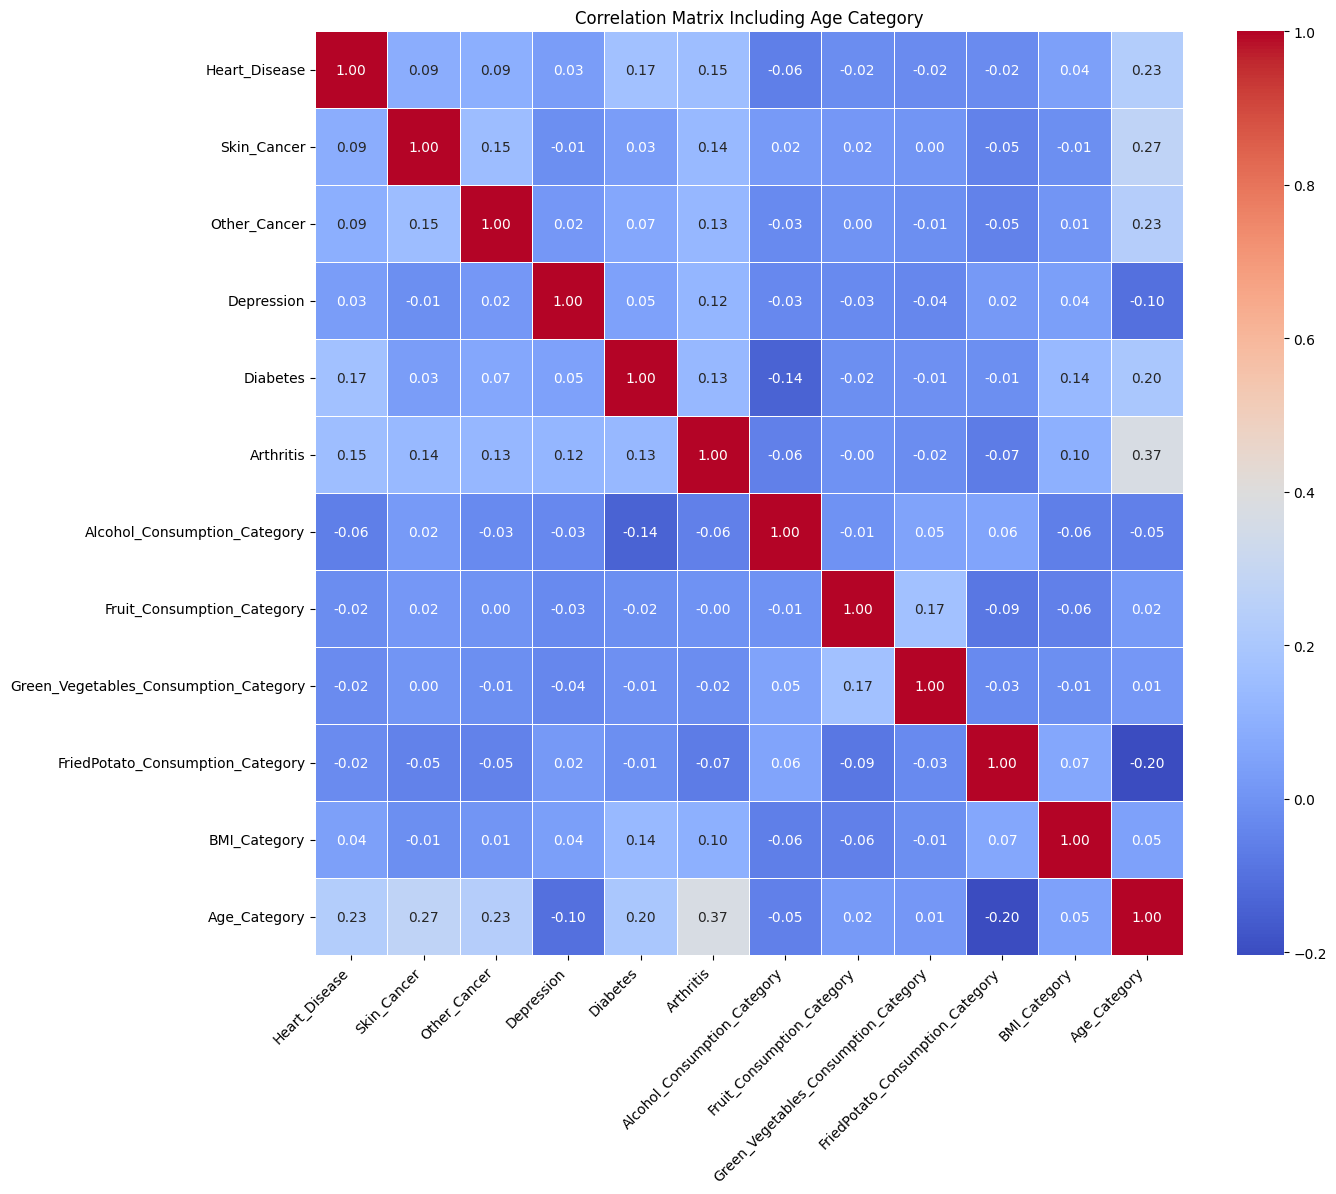

In [10]:


# Encoding health conditions
health_conditions = ['Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis']
for condition in health_conditions:
    data[condition + '_Encoded'] = data[condition].apply(lambda x: 1 if x == 'Yes' else 0)

# Encoding consumption categories
categories = {'No': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Lean': 0, 'Fit': 1, 'Obese': 2}
category_columns = ['Alcohol_Consumption_Category', 'Fruit_Consumption_Category',
                    'Green_Vegetables_Consumption_Category', 'FriedPotato_Consumption_Category', 'BMI_Category']
for column in category_columns:
    data[column + '_Encoded'] = data[column].map(categories)

# Encode Age_Category in an ordinal manner based on sorting
age_categories_sorted = sorted(data['Age_Category'].unique())
data['Age_Category_Encoded'] = data['Age_Category'].apply(lambda x: age_categories_sorted.index(x))

# Update the correlation columns list to include Age_Category
correlation_columns = [col + '_Encoded' for col in (health_conditions + category_columns)] + ['Age_Category_Encoded']

# Create a correlation matrix
correlation_matrix = data[correlation_columns].corr()

# Remove '_Encoded' from the labels for better readability in the heatmap
clean_labels = [col.replace('_Encoded', '') for col in correlation_columns]

# Plotting the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.xticks(ticks=np.arange(len(clean_labels)) + 0.5, labels=clean_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(clean_labels)) + 0.5, labels=clean_labels, rotation=0, ha='right')
plt.title('Correlation Matrix Including Age Category')
plt.show()


### Bayes Theorem: Conditional Probability

In [ ]:
# Reinitialize the DataFrame to store all results across all diseases
combined_results = pd.DataFrame()
all_diseases = ['Heart_Disease_Encoded', 'Skin_Cancer_Encoded', 'Other_Cancer_Encoded',
                'Depression_Encoded', 'Diabetes_Encoded', 'Arthritis_Encoded']
# Loop through each disease and each predictor, calculate probabilities, and format for display
for disease in all_diseases:
    disease_name = disease.replace("_Encoded", "")
    disease_results = pd.DataFrame()

    # Overall prevalence of the disease
    p_d = data[disease].mean()

    # Probabilities of observing each predictor given the disease and overall predictor probabilities
    for predictor in predictors:
        p_x = data[predictor].value_counts(normalize=True)
        p_x_given_d = data.groupby(predictor)[disease].mean()
        p_d_given_x = (p_x_given_d * p_d) / p_x
        temp_df = pd.DataFrame(p_d_given_x, columns=[f'P({disease_name} | {predictor})'])

        # Merge results for the current disease
        disease_results = pd.concat([disease_results, temp_df], axis=1)

    # Combine all disease results with a common index for categories
    if combined_results.empty:
        combined_results = disease_results.reset_index().rename(columns={"index": "Category"})
    else:
        combined_results = pd.merge(combined_results, disease_results.reset_index().rename(columns={"index": "Category"}),
                                    on="Category", how="outer")

# Output the combined results table, ensuring all entries are sorted by Category for consistency
combined_results.sort_values(by="Category", inplace=True)
combined_results.fillna(0, inplace=True)  # Fill NaN with 0 for categories not applicable to some diseases
combined_results.T


### Regression Analysis:

### Model Accuracy Results:

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss

# Define predictors and outcomes
predictors = ['Alcohol_Consumption_Category', 'Fruit_Consumption_Category',
              'Green_Vegetables_Consumption_Category', 'FriedPotato_Consumption_Category',
              'BMI_Category', 'Exercise', 'Sex', 'Smoking_History', 'Age_Category']
outcomes = ['Heart_Disease_Encoded', 'Skin_Cancer_Encoded', 'Other_Cancer_Encoded',
            'Depression_Encoded', 'Diabetes_Encoded', 'Arthritis_Encoded']

# Preprocess categorical variables using OneHotEncoder
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, predictors)
])

# Initialize dictionary to store models and scores
models = {}
scores = {}

# Train a model for each disease and store performance metrics
for outcome in outcomes:
    X_train, X_test, y_train, y_test = train_test_split(
        data[predictors], data[outcome], test_size=0.2, random_state=42)

    clf = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(solver='liblinear', random_state=42))
    ])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    # Store model and calculate metrics
    models[outcome] = clf
    scores[outcome] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_proba),
        'Log Loss': log_loss(y_test, y_proba)
    }

# Create a DataFrame to display the scores
scores_df = pd.DataFrame(scores).T  # Transpose to get diseases as rows
scores_df.index = [i.replace('_Encoded', '') for i in scores_df.index]  # Clean up index names
(scores_df) #Printing the accuracy


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy,Precision,Recall,F1 Score,AUC-ROC,Log Loss
Heart_Disease,0.919023,0.142857,0.000200,0.000400,0.788820,0.239440
Skin_Cancer,0.904178,0.000000,0.000000,0.000000,0.778926,0.270429
Other_Cancer,0.903223,0.000000,0.000000,0.000000,0.738211,0.285347
Depression,0.800359,0.524664,0.018941,0.036562,0.674352,0.469120
Diabetes,0.862249,0.000000,0.000000,0.000000,0.745922,0.354175
Arthritis,0.707970,0.575297,0.407162,0.476842,0.752216,0.537724


### Model Training

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

# Load the data
# file_path = 'path/to/your/dataset.csv'  # Modify with your actual file path
# data = pd.read_csv(file_path)

# Define predictors and the outcomes
predictors = ['Alcohol_Consumption_Category', 'Fruit_Consumption_Category',
              'Green_Vegetables_Consumption_Category', 'FriedPotato_Consumption_Category',
              'BMI_Category', 'Exercise', 'Sex', 'Smoking_History', 'Age_Category']
outcomes = ['Heart_Disease_Encoded', 'Skin_Cancer_Encoded', 'Other_Cancer_Encoded',
            'Depression_Encoded', 'Diabetes_Encoded', 'Arthritis_Encoded']

# Preprocess categorical variables using OneHotEncoder
categorical_features = predictors
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ])

# Initialize dictionary to store models for each disease
models = {}

# Train a model for each disease
for outcome in outcomes:
    # Create training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        data[predictors], data[outcome], test_size=0.2, random_state=42)

    # Create a logistic regression pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression(solver='liblinear', random_state=42))])

    # Train the logistic regression model
    clf.fit(X_train, y_train)

    # Store the model
    models[outcome] = clf



### Model Predicted Results

In [24]:

# Example usage
example_input = {
    'Alcohol_Consumption_Category': 'High',
    'Fruit_Consumption_Category': 'Low',
    'Green_Vegetables_Consumption_Category': 'Medium',
    'FriedPotato_Consumption_Category': 'No',
    'BMI_Category': 'Obese',
    'Exercise': 'Yes',
    'Sex': 'Male',
    'Smoking_History': 'No',
    'Age_Category': '70-74'
}
predicted_probabilities = predict_diseases(example_input)
print(predicted_probabilities)


{'Heart_Disease_Encoded': 0.106281001498669, 'Skin_Cancer_Encoded': 0.22017587848423512, 'Other_Cancer_Encoded': 0.1367322279708376, 'Depression_Encoded': 0.0645799334583173, 'Diabetes_Encoded': 0.11860023063545341, 'Arthritis_Encoded': 0.3899539471057442}
